Loading 9_4.tif...
Building Mini U-Net...
Training (100 epochs to ensure convergence)...
Training Done.
Predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


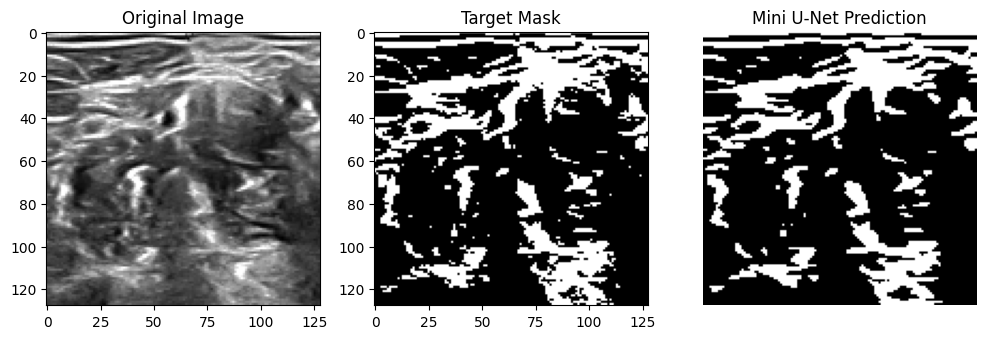

In [6]:
# =============================================================================
# Practical 3: Mini U-Net for Single Image Tumor Detection
# =============================================================================

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ────────────────────────────────────────────────
#   Step 1: Define "Mini" U-Net (Modified Architecture)
# ────────────────────────────────────────────────
def conv_block(x, n_filters):
    # Simplified block: Conv2D -> ReLU (Removed BatchNormalization for single image stability)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    return x

def build_mini_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # 1. Encoder (Downsampling) - Only 2 Levels
    # Level 1
    f1 = conv_block(inputs, 32)
    p1 = layers.MaxPool2D(2)(f1)

    # Level 2
    f2 = conv_block(p1, 64)
    p2 = layers.MaxPool2D(2)(f2)

    # 2. Bottleneck
    bottleneck = conv_block(p2, 128)

    # 3. Decoder (Upsampling)
    # Level 2 Up
    u2 = layers.Conv2DTranspose(64, 3, 2, padding="same")(bottleneck)
    u2 = layers.concatenate([u2, f2])
    u2 = conv_block(u2, 64)

    # Level 1 Up
    u1 = layers.Conv2DTranspose(32, 3, 2, padding="same")(u2)
    u1 = layers.concatenate([u1, f1])
    u1 = conv_block(u1, 32)

    # Output
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u1)

    return models.Model(inputs, outputs, name="Mini-U-Net")

def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# ────────────────────────────────────────────────
#   Step 2: Load Image (Same as before)
# ────────────────────────────────────────────────
def load_single_image(image_path):
    if not os.path.exists(image_path):
        print(f"Error: {image_path} not found. Please upload it!")
        return None, None

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Auto-mask thresholding
    _, mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Normalize
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    mask = np.expand_dims(mask, axis=0)

    return img, mask

# ────────────────────────────────────────────────
#   Step 3: Execution
# ────────────────────────────────────────────────
if __name__ == "__main__":
    IMAGE_FILE = "9_4.tif" # <--- Ensure your file is named this

    print(f"Loading {IMAGE_FILE}...")
    x_train, y_train = load_single_image(IMAGE_FILE)

    if x_train is not None:
        print("Building Mini U-Net...")
        # USE THE NEW MINI MODEL
        model = build_mini_unet(input_shape=(128, 128, 1))

        model.compile(optimizer=Adam(learning_rate=0.001), # Slightly higher LR helps single image
                      loss=dice_loss,
                      metrics=['accuracy'])

        print("Training (100 epochs to ensure convergence)...")
        # Increased epochs because we really want it to memorize this image
        history = model.fit(x_train, y_train,
                            epochs=100,
                            verbose=0) # verbose=0 to reduce clutter, prints 'Done' after
        print("Training Done.")

        # Visualize
        print("Predicting...")
        pred = model.predict(x_train)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.imshow(x_train[0,:,:,0], cmap='gray'); plt.title("Original Image")
        plt.subplot(1, 3, 2); plt.imshow(y_train[0,:,:,0], cmap='gray'); plt.title("Target Mask")
        plt.subplot(1, 3, 3); plt.imshow(pred[0,:,:,0] > 0.5, cmap='gray'); plt.title("Mini U-Net Prediction")
        plt.axis('off')
        plt.show()